## Interference Channel Demo

Author: Cheuk Ting Li  
Based on El Gamal and Kim, _Network Information Theory_, Ch. 6

In [1]:
from psitip import *
PsiOpts.setting(solver = "pyomo.glpk")  # Set linear programming solver
PsiOpts.setting(repr_latex = True)      # Turn on Jupyter Notebook LaTeX display
PsiOpts.setting(venn_latex = True)      # Turn on LaTeX in diagrams

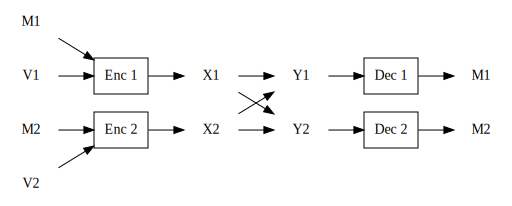

In [2]:
X1, X2 = rv_array("X", 1, 3)
Y1, Y2 = rv_array("Y", 1, 3)
M1, M2 = rv_array("M", 1, 3)
V1, V2 = rv_array("V", 1, 3)
R1, R2 = real_array("R", 1, 3)

# Fully automated inner bound for complicated settings such as interference
# channel is extremely slow. We instead add some manual guidance to allow
# the program to compute the bound more efficiently. Two dummy messages are
# added, which are used by both decoders in simultaneous nonunique decoding.

model = CodingModel()     # Define interference channel [Ahlswede 1974]
model.set_rate(M1, R1)    # Rate of M1 is R1
model.set_rate(M2, R2)    # Rate of M2 is R2
model.set_rate(V1, 0)     # Dummy messages with rate 0
model.set_rate(V2, 0)
model.add_node(M1+V1, X1,
        label = "Enc 1")  # Encoder 1 maps M1,V1 to X1
model.add_node(M2+V2, X2,
        label = "Enc 2")  # Encoder 2 maps M2,V2 to X2
model.add_edge(X1+X2, Y1) # Channel X1,X2 -> Y1
model.add_edge(X1+X2, Y2) # Channel X1,X2 -> Y2
model.add_node(Y1, M1,    # Decoder 1 maps Y1 to M1,
  rv_ndec_force = V1+V2,  # nonunique decoding on V1,V2
  label = "Dec 1")
model.add_node(Y2, M2,    # Decoder 2 maps Y2 to M2,
  rv_ndec_force = V1+V2,  # nonunique decoding on V1,V2
  label = "Dec 2")

model.graph()             # Draw diagram

In [3]:
# Automatic inner bound, gives the inner bound in [Han-Kobayashi 1981]
# ndec_mode = "min" tells the algorithm to only use nonunique
# decoding on variables explicitly marked for nonunique decoding,
# which saves time.
r = model.get_inner(ndec_mode = "min")
r

( ( R1 >= 0 )
 &( R2 >= 0 )
 &( R1 <= I(X1&Y1|Q_T+A_V2) )
 &( R2 <= I(X2&Y2|Q_T+A_V1) )
 &( R1+R2 <= I(X1&Y1|Q_T+A_V1+A_V2)+I(X2+A_V1&Y2|Q_T) )
 &( R1+R2 <= I(X2&Y2|Q_T+A_V2+A_V1)+I(A_V2+X1&Y1|Q_T) )
 &( R1+R2 <= I(A_V1+X2&Y2|Q_T+A_V2)+I(A_V2+X1&Y1|Q_T+A_V1) )
 &( 2*R1+R2 <= I(X1&Y1|Q_T+A_V1+A_V2)+I(A_V2+X1&Y1|Q_T)+I(A_V1+X2&Y2|Q_T+A_V2) )
 &( R1+2*R2 <= I(X2&Y2|Q_T+A_V2+A_V1)+I(X2+A_V1&Y2|Q_T)+I(A_V2+X1&Y1|Q_T+A_V1) )
 &( markov(A_V2+X2, Q_T, A_V1+X1) )
 &( markov(A_V2+Q_T+A_V1, X2+X1, Y1) )
 &( markov(A_V2+Q_T+A_V1+Y1, X2+X1, Y2) ) ).exists(A_V1+A_V2+Q_T)

------
### Z Interference Channel

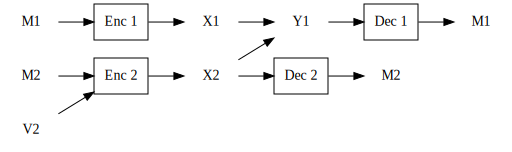

In [5]:
model = CodingModel()     # Define interference channel
model.set_rate(M1, R1)    # Rate of M1 is R1
model.set_rate(M2, R2)    # Rate of M2 is R2
model.set_rate(V2, 0)     # Dummy messages with rate 0
model.add_node(M1, X1,
        label = "Enc 1")  # Encoder 1 maps M1 to X1
model.add_node(M2+V2, X2,
        label = "Enc 2")  # Encoder 2 maps M2,V2 to X2
model.add_edge(X1+X2, Y1) # Channel X1,X2 -> Y1
model.add_node(Y1, M1,    # Decoder 1 maps Y1 to M1
        label = "Dec 1")
model.add_node(X2, M2,    # Decoder 2 maps X2 to M2
        label = "Dec 2")

model.graph()             # Draw diagram

In [7]:
# Automatic inner bound
r = model.get_inner()
r

( ( R1 >= 0 )
 &( R2 >= 0 )
 &( R2 <= H(X2|Q_i) )
 &( R1 <= I(X1&Y1|A_V2+Q_i) )
 &( R1+R2 <= H(X2|A_V2+Q_i)+I(A_V2+X1&Y1|Q_i) )
 &( markov(A_V2+X2, Q_i, X1) )
 &( markov(A_V2+Q_i, X2+X1, Y1) ) ).exists(A_V2+Q_i)

### References
- R. Ahlswede, "The capacity region of a channel with two senders and two receivers," Ann. Probab., vol. 2, no. 5, pp. 805-814, 1974.
-  T. S. Han and K. Kobayashi, "A new achievable rate region for the interference channel," IEEE Trans. Inf. Theory, vol. 27, no. 1, pp. 49-60, Jan. 1981.